# Project 1: Pace vs. Consistency: A Monaco Grand Prix 

## Introduction
This project investigates the role of lap time consistency in Formula 1 race outcomes, moving beyond the traditional focus on raw pace.

Problem: In Formula 1, raw speed is often seen as the primary indicator of performance, but race outcomes are determined over many laps where consistency is crucial. The influence of driver consistency, independent of the car's absolute pace, is not always clearly quantified.

Central Question: To what extent does lap time consistency, independent of raw pace, predict a driver's final race result in Formula 1?

Hypothesis: Drivers with lower lap time variance (higher consistency) are more likely to achieve a better finishing position than their car's raw pace or starting position might otherwise suggest.


## Data Introduction
The data for this analysis was sourced programmatically using the fastf1 Python library, which provides access to official F1 timing data and telemetry.   

Source: fastf1 Python Library (https://docs.fastf1.dev).   

About the Data: The dataset comprises detailed lap-by-lap information from a single event: the 2024 Monaco Grand Prix. This race was selected because it is a track that is known for not having many passes and a better prediction of raw driver speed. 

Key Features:

Driver: The driver's three-letter abbreviation (e.g., 'VER').

LapTime: The duration of each lap.

PitInTime / PitOutTime: Timestamps indicating when a driver entered or exited the pits, used for filtering.


In [2]:
pip install fastf1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Pre-processing the Data

The process of cleaning the data so it can be usable. 

A multi-step pre-processing workflow was essential to isolate representative lap times by removing outliers.

1. Load Session Data: 
    The race session for the 2024 Monaco Grand Prix was loaded from Fastf1. This step is the foundation of the entire project because if not done properly you could have the entire wrong dataset, or not all the required data for the analysis. I also decided to cash the data so it did not have to be called everytime. The data from the fastf1 api is in sql format, so importing it as a mysql file is the best to use from. 

In [3]:
# Import necessary libraries
import fastf1 as ff1
import pandas as pd

# Caching stores data locally
ff1.Cache.enable_cache('../datasets') 

# Load the data for the 2024 Monaco Grand Prix race session
session = ff1.get_session(2024, 'Monaco', 'R')
session.load()

# Extract the lap-by-lap data and the final race results into separate variables
laps = session.laps
results = session.results

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


2. Cleaning The Data:
    The raw race data does not share the whole story as it has inconsistencies and is not fully representable of the drivers pace. First laps, pit in/out laps, and laps under safetly car are all outliers that misrepresent the racing data. By filtering these outliers, we can get a "clean" dataset that more accuratly represents the drivers performance.

In [4]:

# Use pick_quicklaps() to remove outliers like pit laps, first lap, and laps under safety car.
# A threshold of 1.07 means we only keep laps that are within 107% of each driver's fastest lap.
cleaned_laps = laps.pick_quicklaps(threshold=1.07)

# Convert the 'LapTime' column (a timedelta object) to total seconds for statistical analysis.
cleaned_laps = cleaned_laps.copy() 
cleaned_laps['LapTimeSeconds'] = cleaned_laps['LapTime'].dt.total_seconds()



3. Calculating the data: 
    With the now, clean dataset we can perform calculation to the data. This step uses the groupby() to find all the clean laps and calculate the mean (average pace), standard deviation (a measure of variance), and the Coefficient of Variation (CV). The CV is the most important as it shows the pace of each car on equal terms so it is a fair comparison.

In [5]:
# Group the data by 'Driver' and calculate the mean and standard deviation of the clean lap times
driver_stats = cleaned_laps.groupby('Driver')['LapTimeSeconds'].agg(['mean', 'std']).reset_index()

# Calculate the Coefficient of Variation (CV) and add it as a new column.
# CV = (Standard Deviation / Mean) * 100
driver_stats['CV'] = (driver_stats['std'] / driver_stats['mean']) * 100

4. Combining data into one table:
This step is important because it is not combinging the driver stats table with the results table. From merging them, I created a single, comprehensive table that can be used to directly compare the new metrics with the outcomes of the race. 


In [12]:
# Select only the columns you need from the results DataFrame.
race_results = results

# Merge the calculated stats with the race results using the driver abbreviation.
final_table = pd.merge(
    left=race_results, 
    right=driver_stats, 
    left_on='Abbreviation', 
    right_on='Driver'
)

# Rename the columns for a cleaner, more readable table.
final_table = final_table.rename(columns={
    'TeamName': 'Team',
    'GridPosition': 'Grid Position',
    'Position': 'Final Position',
    'mean': 'Mean Lap Time (s)',
    'std': 'Std. Deviation (s)',
    'CV': 'Coefficient of Variation (%)'
})

# Sort the table by the final race position.
final_table = final_table.sort_values(by='Final Position')

# Select and reorder the columns to match the report's format.
final_table = final_table

# Display the final table. Using.to_string() ensures the full table is printed.
print(final_table.to_string())


#Second, Simplified Table 

# Get only relevant info
driver_info = results[['Abbreviation', 'BroadcastName', 'ClassifiedPosition']]

# Merge to add "BroadcastName" to the summary table
simple_table = pd.merge(
    final_table,
    driver_info,
    left_on='Driver',
    right_on='Abbreviation'
)

# Select and order the desired columns
simple_table = simple_table[[
    'Driver',                  # Driver ID
    'FullName',           # Driver name
    'Grid Position',        # Grid position
    'Final Position',      # Final position
    'Mean Lap Time (s)',       # Mean lap time
    'Std. Deviation (s)',      # Lap time deviation
    'Coefficient of Variation (%)'  # CV
]]

# Rename columns for the simplified output
simple_table = simple_table.rename(columns={
    'Driver': 'DriverID',
    'FullName': 'Driver Name',
    'GridPosition': 'Starting Position',
    'Mean Lap Time (s)': 'Mean',
    'Std. Deviation (s)': 'Deviation',
    'Coefficient of Variation (%)': 'CV'
})
#print the simplified table
print("\n\n--- Simplified Statistics Table ---")
print(simple_table.to_string(index=False))

   DriverNumber BroadcastName Abbreviation        DriverId             Team TeamColor        TeamId  FirstName    LastName          FullName                                                                                                                                               HeadshotUrl CountryCode  Final Position ClassifiedPosition  Grid Position  Q1  Q2  Q3                   Time    Status  Points  Laps Driver  Mean Lap Time (s)  Std. Deviation (s)  Coefficient of Variation (%)
0            16     C LECLERC          LEC         leclerc          Ferrari    E80020       ferrari    Charles     Leclerc   Charles Leclerc   https://media.formula1.com/d_driver_fallback_image.png/content/dam/fom-website/drivers/C/CHALEC01_Charles_Leclerc/chalec01.png.transform/1col/image.png         MON             1.0                  1            1.0 NaT NaT NaT 0 days 02:23:15.554000  Finished    25.0  78.0    LEC          77.788000            1.097488                      1.410870
1            81 

## Data Understanding & Visualization
To understand the data, visualations and descriptive analysis must be made. Using Matplotlib and Seaborn will help this process.


This graph uses the table above, which contains lap-by-lap data from the 2024 Monaco Grand Prix. The first step is to clean the data by filtering out any drivers who did not finish the race. From this cleaned dataset, we calculate two key performance indicators for each driver:

Mean Lap Time: To measure their overall pace.

Coefficient of Variation: To measure their lap time consistency


The scatterplot visualizes the relationship between pace and consistency.

Pace (Y-axis): Lower on the chart means a faster average lap time.

Consistency (X-axis): Further to the left means more consistent lap times.

My hypothesis stated that a more consistant(lower CV) would lead to a faster lap pace. According to the data, my prediction was incorrect and it shows a clear trend to a higher consistancy leading to a slower lap pace and a worse consistancy leading to a faster lap pace. 

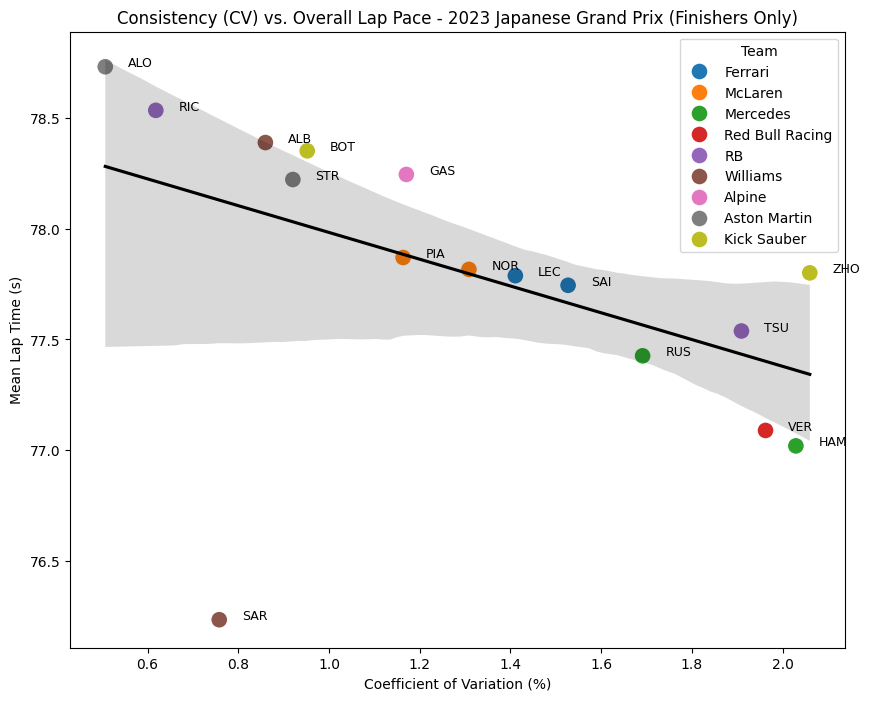

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to exclude DNFs (Status != 'Retired')
finishers = final_table[final_table['Status'] != 'Retired'].copy()

# Plot: CV vs. Mean Lap Time
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=finishers, x='Coefficient of Variation (%)', y='Mean Lap Time (s)', hue='Team', s=150)
ax.set_title('Consistency (CV) vs. Overall Lap Pace - 2023 Japanese Grand Prix (Finishers Only)')
ax.set_xlabel('Coefficient of Variation (%) - Lower = More Consistent →')
ax.set_ylabel('Mean Lap Time (s) - Lower = Faster Pace')

# Add trend line for correlation
sns.regplot(data=finishers, x='Coefficient of Variation (%)', y='Mean Lap Time (s)', scatter=False, color='black', ax=ax)

# Annotations with driver codes
for i in range(len(finishers)):
    ax.text(finishers['Coefficient of Variation (%)'].iloc[i] + 0.05, 
            finishers['Mean Lap Time (s)'].iloc[i], 
            finishers['Driver'].iloc[i], fontsize=9)

plt.show()

## Storytelling

My initial hypothesis that consistent driving leads to better results was proven incorrect. The visualization for the 2024 Monaco Grand Prix showed a clear correlation where a faster lap time meant to less consistancy(higher CV). This suggests top tier f1 racing performance is not about maintaining a consistant fast pace, but more about strategic variation. Using slower laps to conserve resourses and faster push laps to increase overall pace, leads to a lap time variance that is higher. 
Yes, I was able to answer my initial question although it was unexpected. From the analysis of the Monaco GP, a low CV(high consistancy) was linked to a slower lap pace. The main takeaway from the results is that strategic inconsistancy instead of raw consistancy appears to be more valuable. 


## Impact Section

The impact from this project compats the primary goal in most motorsports which is to keep consistancy. The results encourage a shift to strategic stints of driving soft and conserving resources for fast laps of pushing for quicker times. This view provides a more nuanced method for performance.

Possible harm from the visualizations could be from the misinterpretation or oversimplification without knowing the context of the data. Without proper context the results could be interpreted as being inconsistant is always better. This study is also from one a single race so it could be easily generlized, but each race is different and will show slightly different outcomes.

This analysis, as for every race will miss nuance of infinite outside variables such as race traffic, car malfunctions, weather conditions, or other strategic data.


## References
Jupyter notebook templete created by GPT-4.1 in QODO

FastF1 documentation. Retrieved from https://docs.fastf1.dev

Help in interpretation and understanding of data from Google Gemini 2.5 Pro




## Appendix: Full Code



In [8]:
pip install fastf1


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


   DriverNumber BroadcastName Abbreviation        DriverId             Team TeamColor        TeamId  FirstName    LastName          FullName                                                                                                                                               HeadshotUrl CountryCode  Final Position ClassifiedPosition  Grid Position  Q1  Q2  Q3                   Time    Status  Points  Laps Driver  Mean Lap Time (s)  Std. Deviation (s)  Coefficient of Variation (%)
0            16     C LECLERC          LEC         leclerc          Ferrari    E80020       ferrari    Charles     Leclerc   Charles Leclerc   https://media.formula1.com/d_driver_fallback_image.png/content/dam/fom-website/drivers/C/CHALEC01_Charles_Leclerc/chalec01.png.transform/1col/image.png         MON             1.0                  1            1.0 NaT NaT NaT 0 days 02:23:15.554000  Finished    25.0  78.0    LEC          77.788000            1.097488                      1.410870
1            81 

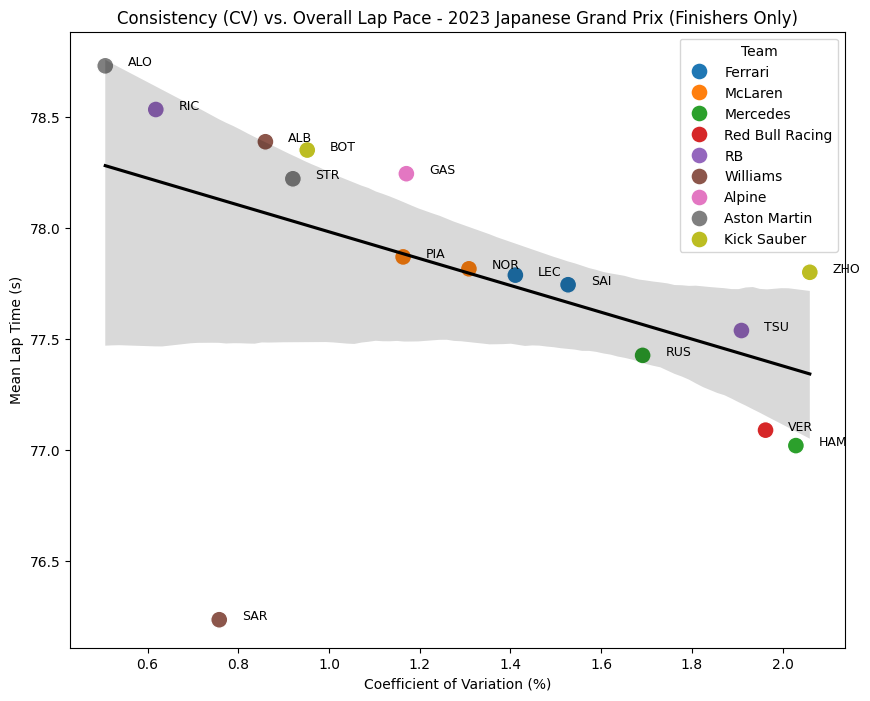

In [9]:
# Import necessary libraries
import fastf1 as ff1
import pandas as pd

# Caching stores data locally
ff1.Cache.enable_cache('../../datasets') 

# Load the data for the 2024 Monaco Grand Prix race session
session = ff1.get_session(2024, 'Monaco', 'R')
session.load()

# Extract the lap-by-lap data and the final race results into separate variables
laps = session.laps
results = session.results

# Use pick_quicklaps() to remove outliers like pit laps, first lap, and laps under safety car.
# A threshold of 1.07 means we only keep laps that are within 107% of each driver's fastest lap.
cleaned_laps = laps.pick_quicklaps(threshold=1.07)

# Convert the 'LapTime' column (a timedelta object) to total seconds for statistical analysis.
cleaned_laps = cleaned_laps.copy() 
cleaned_laps['LapTimeSeconds'] = cleaned_laps['LapTime'].dt.total_seconds()

# Group the data by 'Driver' and calculate the mean and standard deviation of the clean lap times
driver_stats = cleaned_laps.groupby('Driver')['LapTimeSeconds'].agg(['mean', 'std']).reset_index()

# Calculate the Coefficient of Variation (CV) and add it as a new column.
# CV = (Standard Deviation / Mean) * 100
driver_stats['CV'] = (driver_stats['std'] / driver_stats['mean']) * 100

# Select only the columns you need from the results DataFrame.
race_results = results

# Merge the calculated stats with the race results using the driver abbreviation.
final_table = pd.merge(
    left=race_results, 
    right=driver_stats, 
    left_on='Abbreviation', 
    right_on='Driver'
)

# Rename the columns for a cleaner, more readable table.
final_table = final_table.rename(columns={
    'TeamName': 'Team',
    'GridPosition': 'Grid Position',
    'Position': 'Final Position',
    'mean': 'Mean Lap Time (s)',
    'std': 'Std. Deviation (s)',
    'CV': 'Coefficient of Variation (%)'
})

# Sort the table by the final race position.
final_table = final_table.sort_values(by='Final Position')

# Select and reorder the columns to match the report's format.
final_table = final_table

# Display the final table. Using.to_string() ensures the full table is printed.
print(final_table.to_string())


# --- Create the Second, Simplified Table ---

# Get only relevant info (BroadcastName and ClassifiedPosition) from results DataFrame
driver_info = results[['Abbreviation', 'BroadcastName', 'ClassifiedPosition']]

# Merge to add "BroadcastName" to the summary table
simple_table = pd.merge(
    final_table,
    driver_info,
    left_on='Driver',
    right_on='Abbreviation'
)

# Select and order the desired columns
simple_table = simple_table[[
    'Driver',                  # Driver ID
    'FullName',           # Driver broadcast name
    'Grid Position',
    'Final Position',      # Classified position
    'Mean Lap Time (s)',       # Mean lap time
    'Std. Deviation (s)',      # Lap time deviation
    'Coefficient of Variation (%)'  # CV
]]

# Rename columns for the simplified output
simple_table = simple_table.rename(columns={
    'Driver': 'DriverID',
    'BroadcastName': 'BroadcastName',
    'ClassifiedPosition': 'Classified Position',
    'Mean Lap Time (s)': 'Mean',
    'Std. Deviation (s)': 'Deviation',
    'Coefficient of Variation (%)': 'CV'
})

print("\n\n--- Simplified Statistics Table ---")
print(simple_table.to_string(index=False))
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to exclude DNFs (Status != 'Retired')
finishers = final_table[final_table['Status'] != 'Retired'].copy()

# Plot: CV vs. Mean Lap Time
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=finishers, x='Coefficient of Variation (%)', y='Mean Lap Time (s)', hue='Team', s=150)
ax.set_title('Consistency (CV) vs. Overall Lap Pace - 2023 Japanese Grand Prix (Finishers Only)')
ax.set_xlabel('Coefficient of Variation (%) - Lower = More Consistent →')
ax.set_ylabel('Mean Lap Time (s) - Lower = Faster Pace')

# Add trend line for correlation
sns.regplot(data=finishers, x='Coefficient of Variation (%)', y='Mean Lap Time (s)', scatter=False, color='black', ax=ax)

# Annotations with driver codes
for i in range(len(finishers)):
    ax.text(finishers['Coefficient of Variation (%)'].iloc[i] + 0.05, 
            finishers['Mean Lap Time (s)'].iloc[i], 
            finishers['Driver'].iloc[i], fontsize=9)

plt.show()